In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import plotly.express as px
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

In [7]:
sales_df=pd.read_csv('processed.csv')

In [8]:
print(sales_df)

      QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  MONTH_ID  YEAR_ID  \
0                  30      95.70                2  2871.00         2     2003   
1                  34      81.35                5  2765.90         5     2003   
2                  41      94.74                2  3884.34         7     2003   
3                  45      83.26                6  3746.70         8     2003   
4                  49     100.00               14  5205.27        10     2003   
...               ...        ...              ...      ...       ...      ...   
2818               20     100.00               15  2244.40        12     2004   
2819               29     100.00                1  3978.51         1     2005   
2820               43     100.00                4  5417.57         3     2005   
2821               34      62.24                1  2116.16         3     2005   
2822               47      65.52                9  3079.44         5     2005   

      MSRP  PRODUCTCODE  Au

In [9]:
# Scale the data
scaler = StandardScaler()
sales_df_scaled = scaler.fit_transform(sales_df)
print(sales_df_scaled.shape)

(2823, 37)


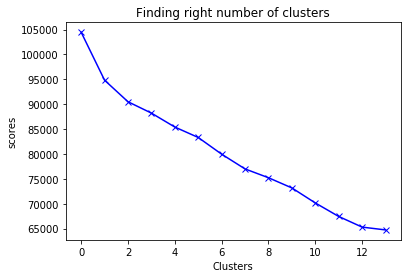

In [13]:
scores = []

range_values = range(1, 15)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(sales_df_scaled)
  scores.append(kmeans.inertia_) # intertia is the Sum of squared distances of samples to their closest cluster center

plt.plot(scores, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores') 
plt.show()

In [15]:
#the visualization of elbow is difficult as seen in figure
#lets take 7 as cluster size as a elbow like structure is visible
# Cluster the data using k-means
kmeans = KMeans(7)
kmeans.fit(sales_df_scaled)
labels = kmeans.labels_
kmeans.cluster_centers_.shape
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])
print(cluster_centers )

  QUANTITYORDERED PRICEEACH ORDERLINENUMBER     SALES  MONTH_ID   YEAR_ID  \
0       -0.445681 -0.770211        0.032622 -0.819265  0.034340 -0.044444   
1       -0.064370 -0.172913        0.142506 -0.329345 -0.016501  0.132286   
2        1.249875  0.800027       -0.273244  2.571784 -0.083901  0.125091   
3       -0.173920 -0.039573       -0.005290 -0.189818  0.073057 -0.000691   
4        0.265388  0.599659       -0.016848  0.468445  0.011827 -0.045788   
5        0.033909 -0.057189        0.117244  0.035146 -0.603897  0.539232   
6       -0.261543  0.190162       -0.354187 -0.145888 -0.381699  0.524237   

       MSRP PRODUCTCODE Australia   Austria  ... Classic Cars Motorcycles  \
0 -0.600674    0.208637 -0.264819 -0.010728  ...    -0.055933    0.055169   
1 -0.363335    0.878437 -0.264819  0.004323  ...    -0.721812   -0.364452   
2  1.435041   -0.879878 -0.081137  0.046965  ...     0.578093    0.019040   
3 -0.072337   -0.135140  3.776170 -0.140961  ...    -0.118060    0.054645  

In [16]:
# In order to understand what these numbers mean, let's perform inverse transformation
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [sales_df.columns])
print(cluster_centers)
#we can analyse the clusers on basis of sales, quantity orders , price,MSRP
#however the cluster look relatively closer and are difficult to analyse 
#so we perform dimensionality reduction techniques for better clustering 


  QUANTITYORDERED  PRICEEACH ORDERLINENUMBER        SALES  MONTH_ID  \
0       30.752000  68.122840        6.604000  2045.180850  7.218000   
1       34.465863  80.170763        7.068273  2947.388313  7.032129   
2       47.266234  99.795649        5.311688  8289.929221  6.785714   
3       33.398876  82.860337        6.443820  3204.331798  7.359551   
4       37.677615  95.754080        6.394987  4416.549455  7.135696   
5       35.423077  82.505000        6.961538  3618.611731  4.884615   
6       32.545455  87.494242        4.969697  3285.230909  5.696970   

       YEAR_ID        MSRP PRODUCTCODE     Australia       Austria  ...  \
0  2003.784000   76.580000   60.362000 -1.387779e-16  1.800000e-02  ...   
1  2003.907631   86.116466   81.514056 -1.387779e-17  2.008032e-02  ...   
2  2003.902597  158.376623   25.987013  4.545455e-02  2.597403e-02  ...   
3  2003.814607   97.808989   49.505618  1.000000e+00  6.938894e-18  ...   
4  2003.783060  117.503889   46.116681 -6.938894e-17  2.

In [41]:
#we can perform PCA for dimesionality reduction
#This will make clustering easier
pca = PCA(n_components = 3)
principal_comp = pca.fit_transform(sales_df_scaled)
pca_df = pd.DataFrame(data = principal_comp, columns = ['pca1', 'pca2', 'pca3'])
print(pca_df)


          pca1      pca2      pca3
0    -0.486326 -1.225005  1.024670
1    -0.784736 -1.026402  1.483383
2     1.431368  0.122297  0.327609
3     1.288382 -0.230873 -0.558873
4     1.975982 -0.132785 -1.029970
...        ...       ...       ...
2818 -2.450235  1.111110 -1.508094
2819 -0.158183  3.723973  0.692482
2820  0.389927  4.078723 -0.066699
2821 -2.788783  2.396923  1.582286
2822 -0.705363  3.318945 -0.524134

[2823 rows x 3 columns]


In [42]:
pca_df=pd.concat([pca_df,pd.DataFrame({'cluster':labels})],axis=1)
print(pca_df)

          pca1      pca2      pca3  cluster
0    -0.486326 -1.225005  1.024670        0
1    -0.784736 -1.026402  1.483383        0
2     1.431368  0.122297  0.327609        4
3     1.288382 -0.230873 -0.558873        4
4     1.975982 -0.132785 -1.029970        4
...        ...       ...       ...      ...
2818 -2.450235  1.111110 -1.508094        0
2819 -0.158183  3.723973  0.692482        4
2820  0.389927  4.078723 -0.066699        4
2821 -2.788783  2.396923  1.582286        0
2822 -0.705363  3.318945 -0.524134        4

[2823 rows x 4 columns]


In [43]:
# Visualize clusters using 3D-Scatterplot
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3',color='cluster')
fig.show()

In [44]:
#using autoencoder for data compression
input_df = Input(shape = (37,))
x = Dense(50, activation = 'relu')(input_df)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
encoded = Dense(8, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
decoded = Dense(37, kernel_initializer = 'glorot_uniform')(x)

# autoencoder
autoencoder = Model(input_df, decoded)

# encoder - used for dimensionality reduction
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer = 'adam', loss='mean_squared_error')

In [45]:
autoencoder.fit(sales_df, sales_df, batch_size = 128, epochs = 500, verbose = 3)

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

In [46]:
autoencoder.save_weights('autoencoder_1.h5')


In [47]:
pred = encoder.predict(sales_df_scaled)

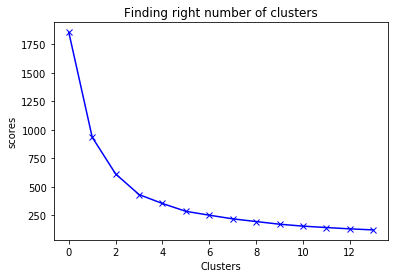

In [48]:
scores = []

range_values = range(1, 15)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(pred)
  scores.append(kmeans.inertia_)

plt.plot(scores, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores') 
plt.show()

In [49]:
#the elbow is now visible as 3
kmeans = KMeans(3)
kmeans.fit(pred)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(sales_df_scaled)
df_cluster_dr = pd.concat([sales_df, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster_dr.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,cluster
0,30,95.70,2,2871.00,2,2003,95,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,34,81.35,5,2765.90,5,2003,95,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,41,94.74,2,3884.34,7,2003,95,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,45,83.26,6,3746.70,8,2003,95,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,49,100.00,14,5205.27,10,2003,95,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [50]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])
print(cluster_centers) 

  QUANTITYORDERED PRICEEACH ORDERLINENUMBER     SALES  MONTH_ID   YEAR_ID  \
0       -0.468912 -0.724370        0.043454 -0.810304  0.007142 -0.003285   
1        0.293073  0.580208       -0.010805  0.458608  0.003368 -0.012482   
2        1.245428  0.800220       -0.259579  2.573861 -0.088008  0.136857   

       MSRP PRODUCTCODE Australia   Austria  ... Classic Cars Motorcycles  \
0 -0.581757    0.285478  0.025174 -0.016801  ...    -0.162957    0.013781   
1  0.376634   -0.165542 -0.013717  0.010642  ...     0.085141   -0.014094   
2  1.430265   -0.871802 -0.084647  0.043374  ...     0.580097    0.011712   

     Planes     Ships    Trains Trucks and Buses Vintage Cars     Large  \
0  0.072858  0.058660  0.071986        -0.044714     0.087993 -0.242672   
1 -0.048853 -0.020232 -0.052121         0.064221    -0.064346 -0.242672   
2 -0.164278 -0.300637 -0.128350        -0.201008    -0.151285  4.120788   

     Medium    Small  
0 -0.980703  1.09637  
1  1.019676 -0.91210  
2 -0.980703 

In [51]:
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [sales_df.columns])
print(cluster_centers)

  QUANTITYORDERED  PRICEEACH ORDERLINENUMBER        SALES  MONTH_ID  \
0       30.525741  69.047496        6.649766  2061.682800  7.118565   
1       37.947254  95.361741        6.420520  4398.433699  7.104769   
2       47.222930  99.799554        5.369427  8293.753248  6.770701   

       YEAR_ID        MSRP PRODUCTCODE Australia   Austria  ... Classic Cars  \
0  2003.812793   77.340094   62.788612  0.071763  0.017161  ...     0.265211   
1  2003.806358  115.848988   48.545520  0.062139  0.020954  ...     0.382948   
2  2003.910828  158.184713   26.242038  0.044586  0.025478  ...     0.617834   

  Motorcycles    Planes         Ships    Trains Trucks and Buses Vintage Cars  \
0    0.121685  0.131045  9.906396e-02  0.039002         0.092824     0.251170   
1    0.112717  0.093208  7.731214e-02  0.018786         0.126445     0.188584   
2    0.121019  0.057325 -5.551115e-17  0.006369         0.044586     0.152866   

          Large        Medium         Small  
0  1.457168e-16 -9.9920

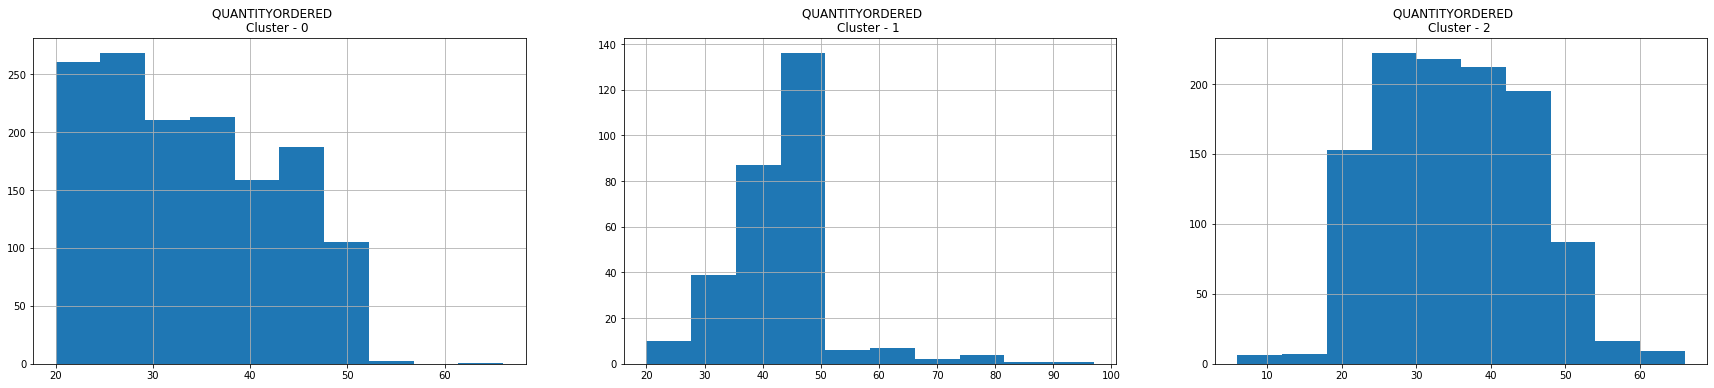

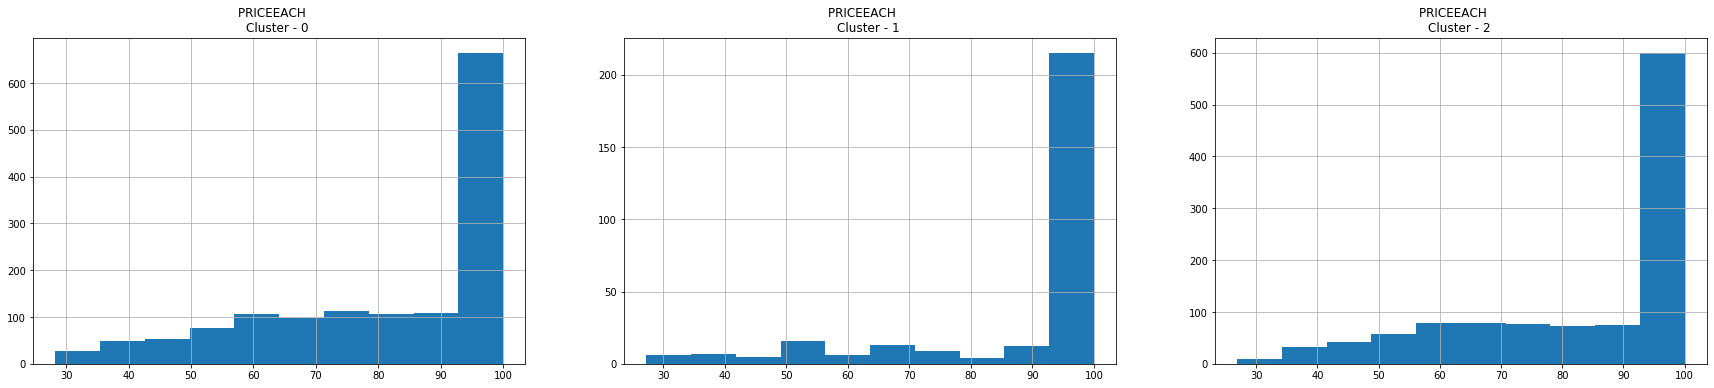

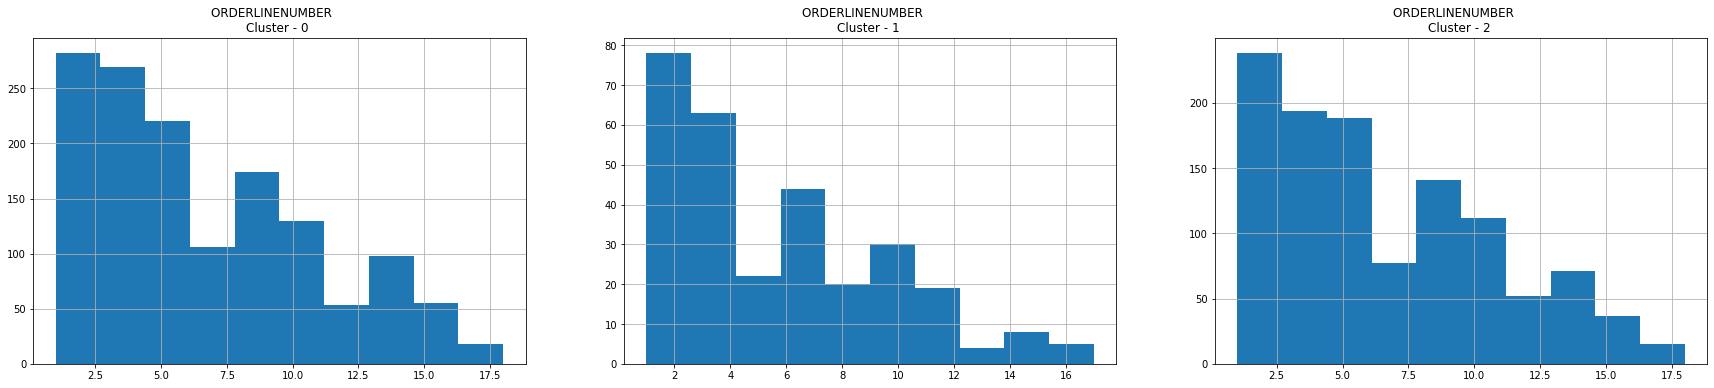

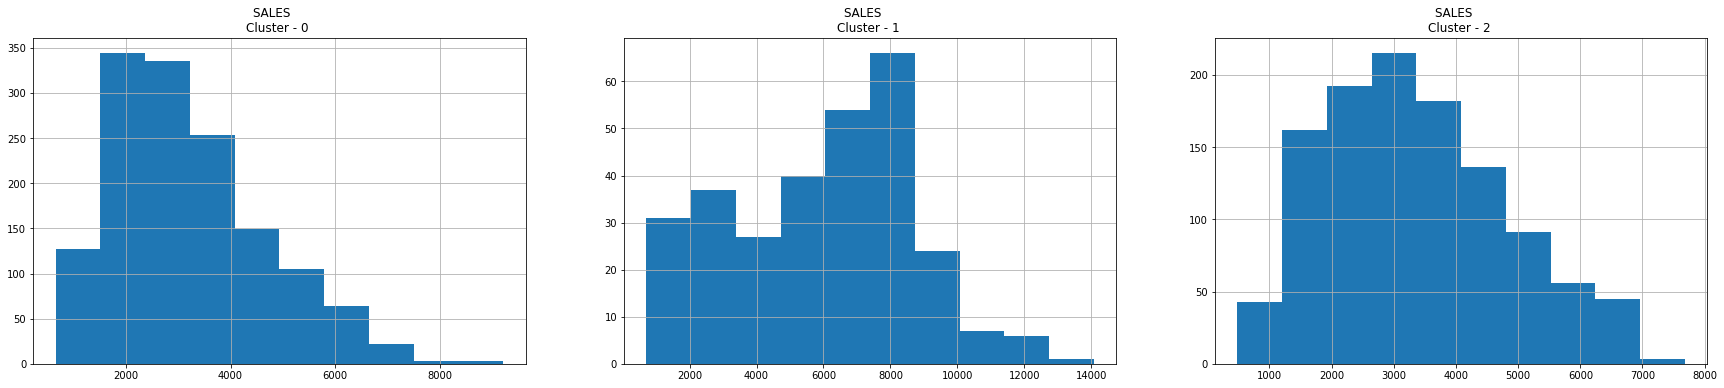

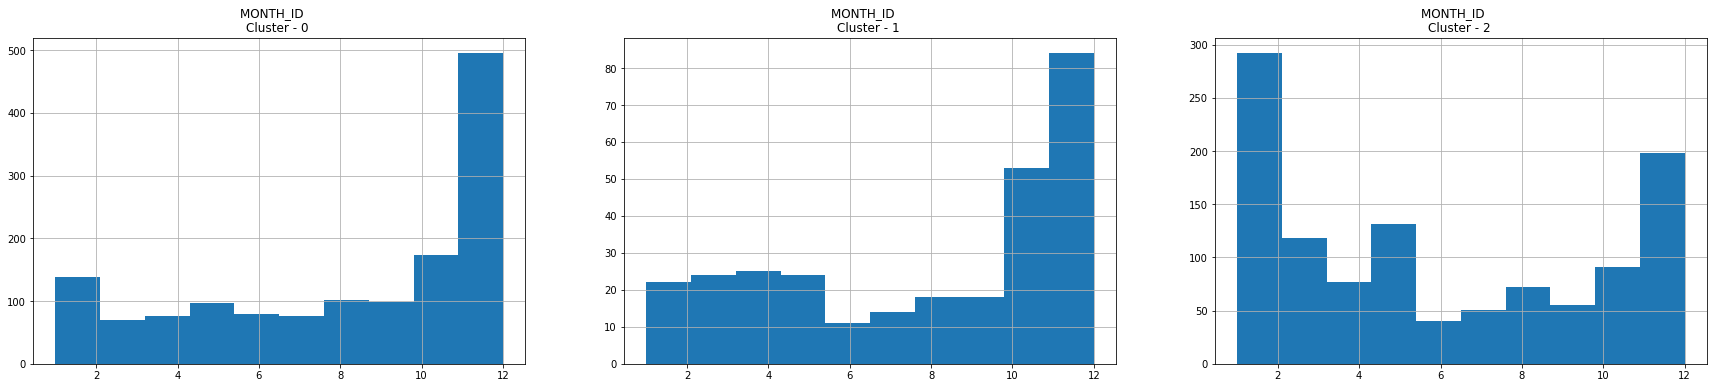

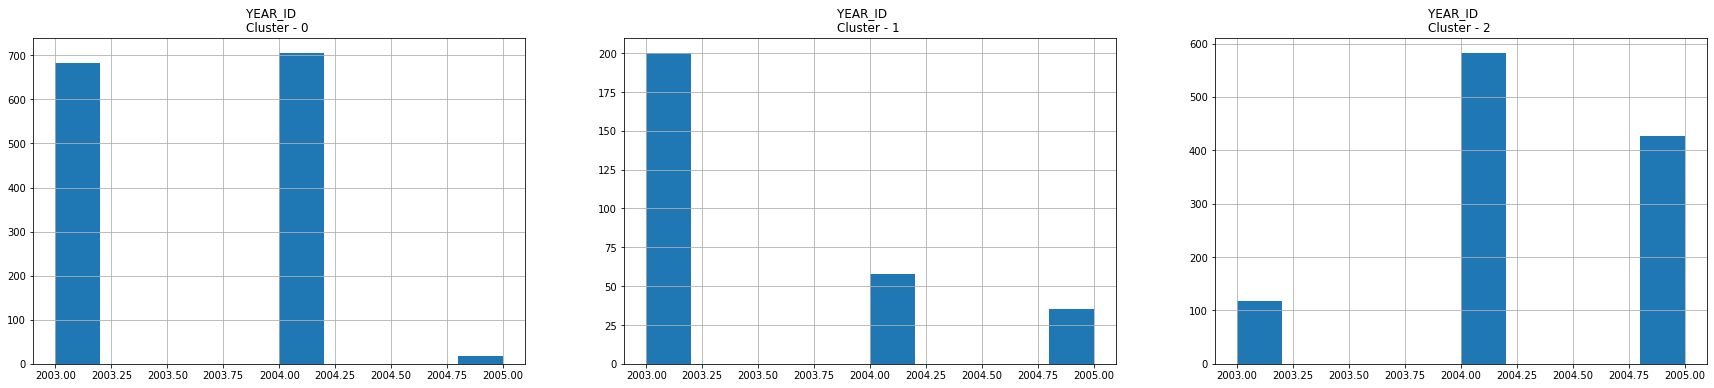

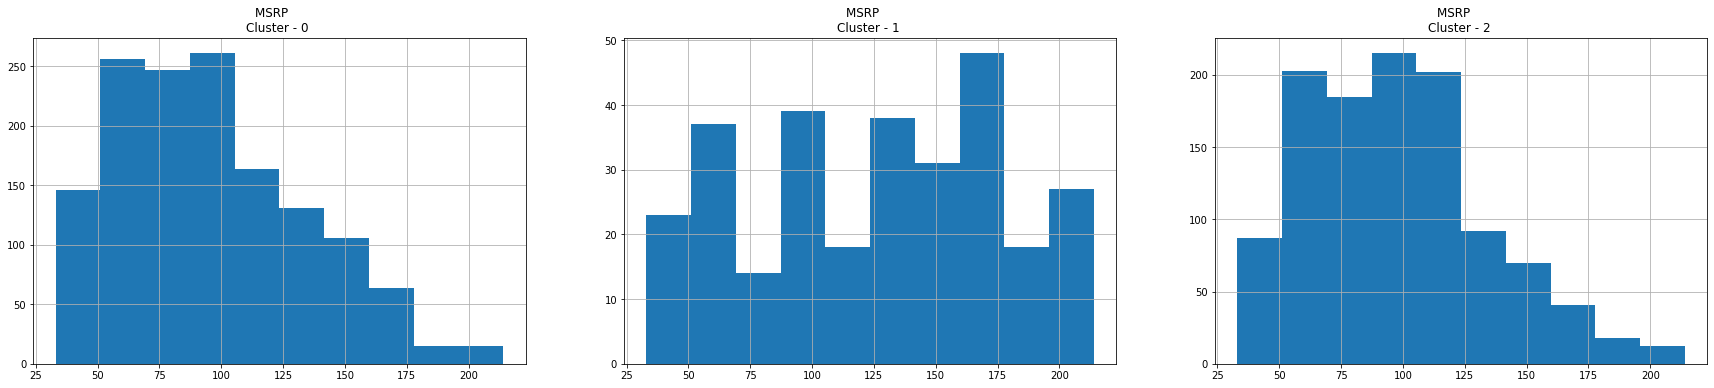

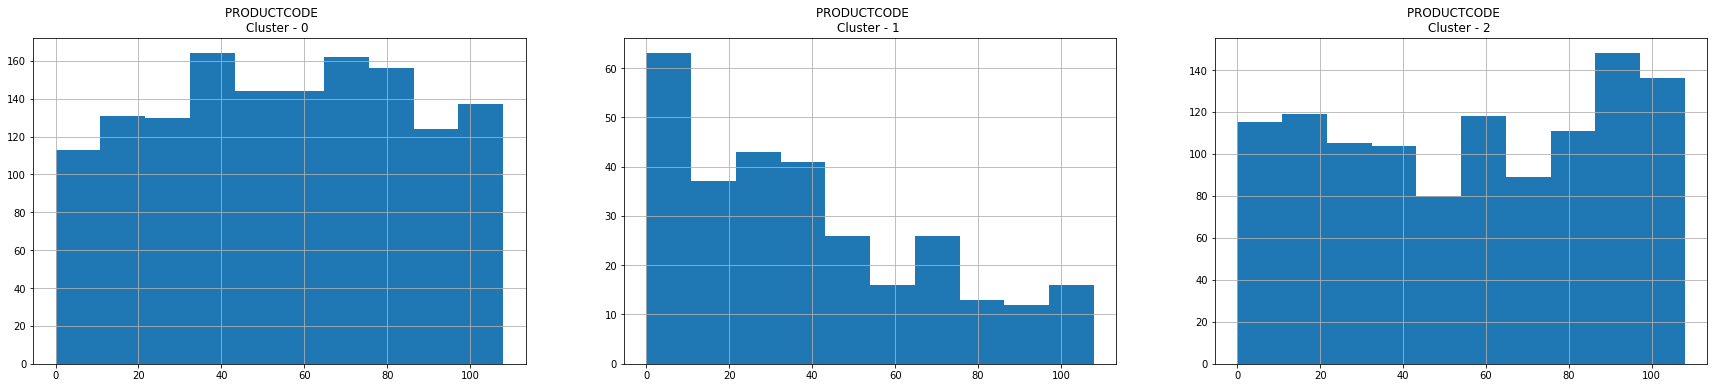

In [52]:
# plot histogram for each feature based on cluster 
#this will help to analyse each feature wrt cluster
for i in sales_df.columns[:8]:
  plt.figure(figsize = (30, 6))
  for j in range(3):
    plt.subplot(1, 3, j+1)
    cluster = df_cluster_dr[df_cluster_dr['cluster'] == j]
    cluster[i].hist()
    plt.title('{}    \nCluster - {} '.format(i,j))
  
  plt.show()